<a href="https://colab.research.google.com/github/urness/CS167Fall22Code/blob/main/Day15NotesRandomForests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 15 Notes: Random Forests

Using a new dataset, this set of notes walks through how to use Random Forests in sklearn, and also demonstrates tuning different parameters related to Random Forests. 

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
data= pd.read_csv('/content/drive/MyDrive/CS167Fall22/Datasets/breast-cancer-wisconsin-data.csv')
data.head()

In [ ]:
# Notice that the 'Unnamed: 32' column is full of NaN... we need to get rid of it. 
data.drop('Unnamed: 32', inplace=True, axis=1)
data.isna().any()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

target = "diagnosis"
predictors = data.columns.drop(target) #gets all of the columns except the target

train_data, test_data, train_sln, test_sln = train_test_split(data[predictors], data[target], test_size = 0.2, random_state=41)

In [ ]:
from sklearn import tree
from sklearn import metrics

# Let's use a single tree for comparison
# a default Decision Tree Classifier

dt = tree.DecisionTreeClassifier(random_state = 0)
dt.fit(train_data,train_sln)
predictions = dt.predict(test_data)

print("SINGLE DECISION TREE accuracy score: ", metrics.accuracy_score(test_sln,predictions))
vals = data[target].unique() ## possible classification values (M = malignant; B = benign)
conf_mat = metrics.confusion_matrix(test_sln, predictions, labels=vals)
print(pd.DataFrame(conf_mat, index = "True " + vals, columns = "Predicted " + vals))

In [ ]:
# a Random Forest Classifier
forest = RandomForestClassifier(random_state = 0, n_estimators=100)
forest.fit(train_data,train_sln)
predictions = forest.predict(test_data)
print("RANDOM FOREST accuracy score: ", metrics.accuracy_score(test_sln,predictions))

vals = data[target].unique() ## possible classification values (M = malignant; B = benign)
conf_mat = metrics.confusion_matrix(test_sln, predictions, labels=vals)
print(pd.DataFrame(conf_mat, index = "True " + vals, columns = "Predicted " + vals))

# Exercise #1
Look at RandomForestClassifer Documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier)

- What is the default number of trees?
- How does increasing or decreasing the number of trees effect accuracy?

# Exercise #2
Can you improve upon the Breast cancer diagnosis accuracy?
Can you get 100% accuracy? Why do you think so?


## Feature Importances
Becuase we are building so many small decision trees in a random forest, we have the added benefit of being able to see what features are most commonly used as high **information gain** features. The code below shows how we can plot the 'Feature Importance' chart for a random forest. 

In this particular run, it looks like `perimeter_worst` or `concave points_worst` was the most important feature, but there were a handful of others that were important as well. 

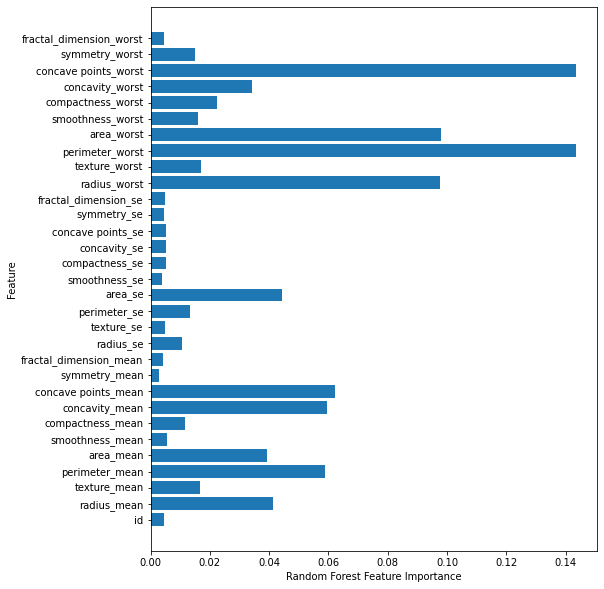

In [8]:
# It looks like our random forest model achieved pretty good accuracy. 
# Now lets check how important each of the features was in the ensemble of models we built.

import matplotlib.pyplot as plt
%matplotlib inline

index = range(len(predictors)) #creates a list of numbers the right size to use as the index

plt.figure(figsize=(8,10)) #making the table a bit bigger so the text is readable
plt.barh(index,forest.feature_importances_,height=0.8) #horizontal bar chart
plt.ylabel('Feature')
plt.yticks(index,predictors) #put the feature names at the y tick marks
plt.xlabel("Random Forest Feature Importance")
plt.show()


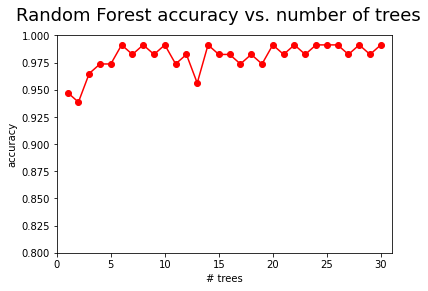

In [9]:
#This function just loops through a series of n_estimator values, builds a different model
#for each, and then plots their respective accuracies. By making it a function, it's easier
#to try out different ranges of numbers
import matplotlib.pyplot as plt

def tune_number_of_trees(n_estimator_values):
    rf_accuracies = []

    for n in n_estimator_values:

        curr_rf = RandomForestClassifier(n_estimators=n, random_state=41)
        curr_rf.fit(train_data,train_sln)
        curr_predictions = curr_rf.predict(test_data)
        curr_accuracy = metrics.accuracy_score(test_sln,curr_predictions)
        rf_accuracies.append(curr_accuracy)


    plt.suptitle('Random Forest accuracy vs. number of trees',fontsize=18)
    plt.xlabel('# trees')
    plt.ylabel('accuracy')
    plt.plot(n_estimator_values,rf_accuracies,'ro-')
    plt.axis([0,n_estimator_values[-1]+1,.8,1])

    plt.show()
    
tune_number_of_trees(range(1,31))



It looks like whether we are using small numbers of trees or large ones, the accuracy stays about the same. It appears at least sometimes that Random Forest doesn't take a lot of tuning of the number of trees.

Now let's try tuning the number of features used with each tree.

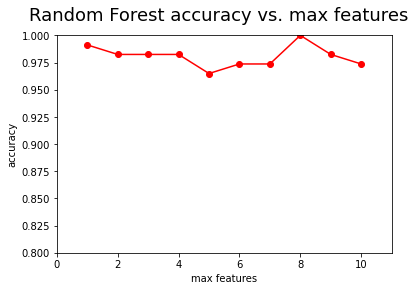

In [10]:
def tune_max_features(max_features_values):
    rf_accuracies = []

    for m in max_features_values:

        curr_rf = RandomForestClassifier(n_estimators=10,max_features=m, random_state=31)
        curr_rf.fit(train_data,train_sln)
        curr_predictions = curr_rf.predict(test_data)
        curr_accuracy = metrics.accuracy_score(test_sln,curr_predictions)
        rf_accuracies.append(curr_accuracy)


    plt.suptitle('Random Forest accuracy vs. max features',fontsize=18)
    plt.xlabel('max features')
    plt.ylabel('accuracy')
    plt.plot(max_features_values,rf_accuracies,'ro-')
    plt.axis([0,max_features_values[-1]+1,.8,1])

    plt.show()
    
tune_max_features(range(1,11))

Note that the above could be subject to changes based on the initial random_state.

For this data, which is apparently very easy to learn on (accuracy is very high), the number of features used with each tree also didn't matter much when used with an ensemble of 10 trees. This is probably something worth tuning if you have a lot of features, especially if many of them might not be very relevant.

# Exercise #4 
Apply random forest to the wine dataset (Notebook 3)
Can you get an R2 score above .55?


In [11]:
import sklearn
import pandas
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

wine = pandas.read_csv('/content/drive/MyDrive/CS167Fall22/Datasets/winequality-white.csv') # change this to match your dataset directory

target= 'quality'
predictors = wine.columns.drop(target)
train_data, test_data, train_sln, test_sln = train_test_split(wine[predictors], wine[target], test_size = 0.2, random_state=41)

In [12]:
forest = RandomForestRegressor()
forest.fit(train_data,train_sln)
predictions = forest.predict(test_data)
print('MSE: ', metrics.mean_squared_error(test_sln, predictions))
print('r2: ', metrics.r2_score(test_sln, predictions))

MSE:  0.2882275
r2:  0.5392967032967032
